# TTC Delay Analysis

I've personally experienced many painful delays while traveling to work on the TTC and finally motivated myself to understand the how and why they happen. The data was surprisingly easy to obtain as the Ontario government is pretty transparent on public transportation information. The data is available in the TTC Project folder and can also be found with the following link (https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/). Keep in mind that I've renamed the files as they were named inconsistently and it would make it easier to combine.


In [1]:
# Essential libraries for math operations and visualizations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# Machine learning libraries
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


# Utilities
from sklearn.metrics import mean_squared_error
from datetime import datetime, date, time 
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller
from time import sleep
from fbprophet import Prophet

import warnings

#customizations
plt.style.use('ggplot')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (18, 8)
plt.rcParams['text.color'] = 'k'

Lets look at a small slice of our data to see what features and data types we have available to us

In [2]:
df = pd.read_excel('data/SubwaySRTLogs201805.xlsx')
df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2018-05-01,00:18,Tuesday,OLD MILL STATION,MUI,9,13,W,BD,5077
1,2018-05-01,00:29,Tuesday,YUS/BD/SHEPPARD SUBWAY,TUO,0,0,W,BD,5234
2,2018-05-01,02:01,Tuesday,MCCOWAN YARD,PRSP,0,0,N,SRT,3015
3,2018-05-01,02:41,Tuesday,VAUGHAN MC STATION,SUO,0,0,NaN,YU,0
4,2018-05-01,05:47,Tuesday,KIPLING STATION,MUSC,0,0,E,BD,5120


Date - day of the year (YYYY/MM/DD)  
Time - Time of day in 24h format  
Day  - Name of the day of the week  
Station - TTC subway station name  
Code - TTC delay code  
Min Delay - Delay to subway service (in minutess)  
Min Gap - Time length between trains (in minutess)  
Bound - Direction of train dependant on the line  
Line - TTC subway line i.e. YU, BD, SHP, and SRT  
Vehicle - TTC train number  

Now that we get a picture of what our tables look like, we will now combine all the data using regular expression to select the appropriate files. Note that this was why we renamed the files earlier. The result will be a table with a shape of (99479, 10).



In [3]:
regex = re.compile(r'SubwaySRTLogs.*')
files = os.listdir('./data')
file = filter(regex.search, files)

all_data = pd.DataFrame()
for datafile in file:
    df = pd.read_excel('data/' +  datafile)
    all_data = all_data.append(df)
    
all_data.shape
#stringColumns = ['Day', 'Station', 'Code', 'Bound', 'Line', 'Vehicle']
#all_data[stringColumns] = all_data[stringColumns].astype(str) 

(99479, 10)

## Data Cleansing

Now that the data has been combined we will clean as much of it as we can before we split it into training and testing sets. We first look at how much data is missing in the resulting table and will decide on whether or not we throw it out or impute it. 

INFO:numexpr.utils:NumExpr defaulting to 6 threads.


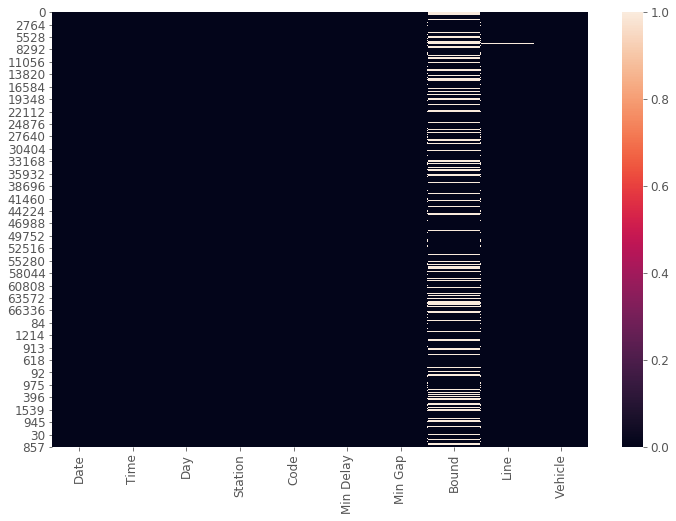

In [4]:
plt.figure(figsize=(12,8))
sns.heatmap(all_data.isnull())

We end up seeing a lot of missing data for Bound and a few for Line so we will remove all of it and any data related to the SRT line. The reason being is because we want to focus on delays near the downtown core and the SRT data will only muddy our predictive model. There were also inconsistent naming conventions fouund in the Station, Line, and Bound columns so we will remove those as well.

# Feature Engineering

Now we start creating some features based on our knowledge around how the subway operates

In [4]:
all_data.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111
1,2014-01-01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001
2,2014-01-01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0
3,2014-01-01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116
4,2014-01-01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386


In [4]:
# This column will be a boolean value representing whether there is a delay or not. It will also be our y-value 
all_data['Delay'] = all_data['Min Delay'].apply(lambda x: x>0) * 1

INFO:numexpr.utils:NumExpr defaulting to 6 threads.


In [5]:
drop_cols = ['Time', 'Day', 'Station', 'Code', 'Min Delay', 'Min Gap',
       'Bound', 'Line', 'Vehicle']
y = all_data.drop(drop_cols, axis='columns')
y = (y.groupby('Date')[['Delay']]
      .sum()
      )
y.head()

,Delay
Date,
2014-01-01,28
2014-01-02,31
2014-01-03,25
2014-01-04,13
2014-01-05,15


# Exploratory Data Analysis

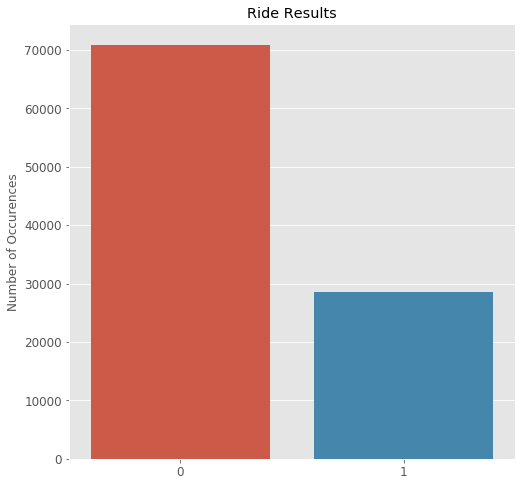

In [63]:
plt.figure(figsize=(8,8))
sns.barplot(x =all_data.Delay.value_counts().index, y=all_data.Delay.value_counts())
plt.title('Ride Results')

plt.ylabel('Number of Occurences');


Text(0.5, 1.0, 'Daily Delays Over 5 Years')

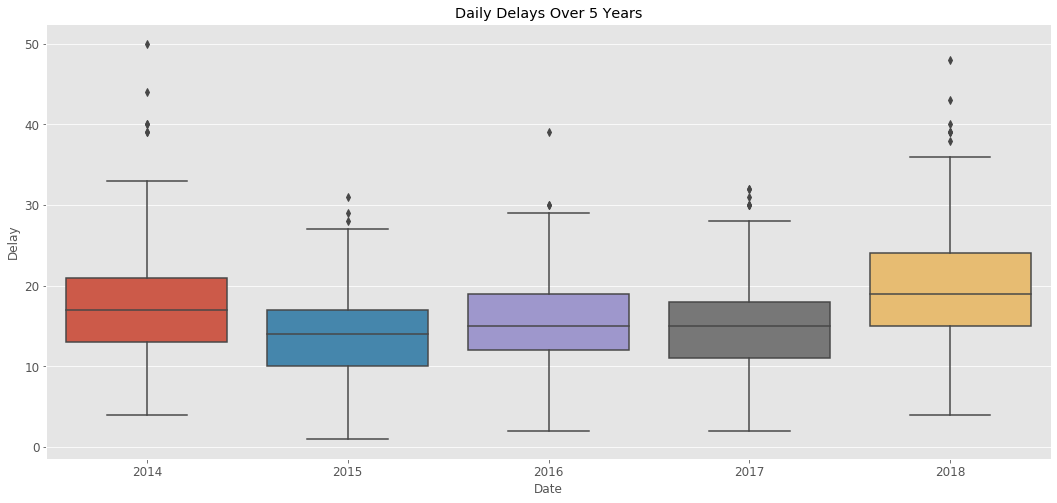

In [18]:
all_data_year = all_data.set_index('Date').resample('A')['Delay'].sum().reset_index()
sns.boxplot(x=y.index.year, y=y.Delay)
plt.title('Daily Delays Over 5 Years')

data was aggregated to show average delays in a day for a given month

Text(0, 0.5, 'Probability')

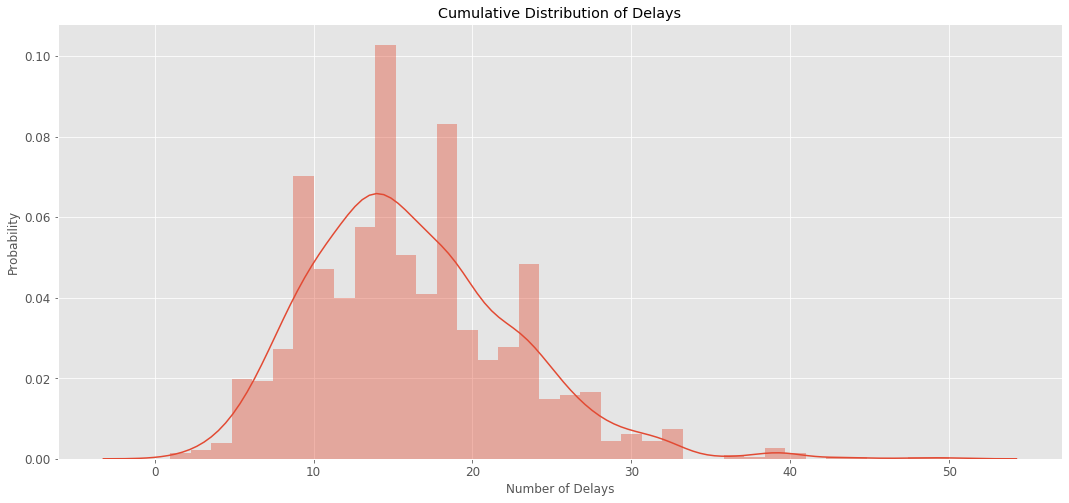

In [56]:
sns.distplot(y.Delay)
plt.title('Cumulative Distribution of Delays')
plt.xlabel('Number of Delays')
plt.ylabel('Probability')

distribution seems to be left shifted. We may see some benefit applying power transformations on the data to achieve a gaussian distribution

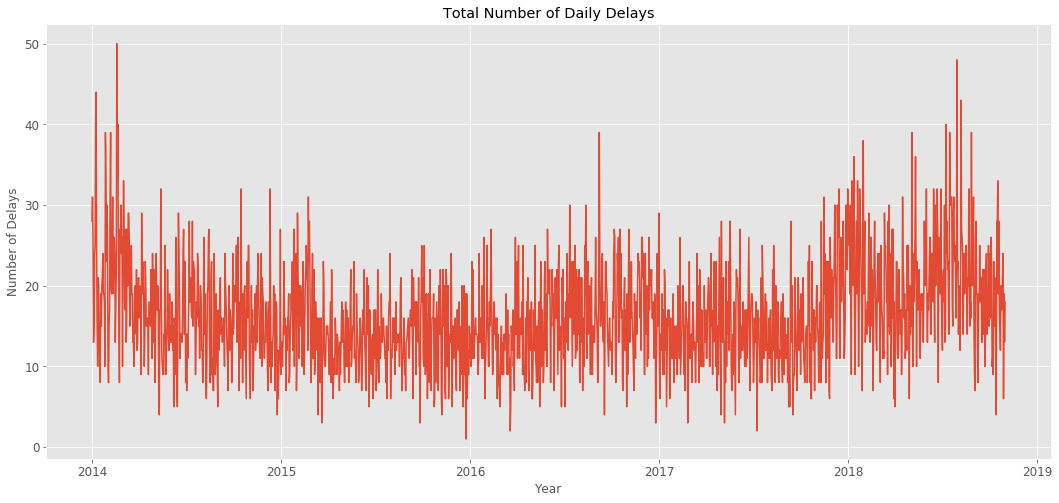

In [64]:
plt.title('Total Number of Daily Delays')
plt.ylabel('Number of Delays')
plt.xlabel('Year')
plt.plot(y.Delay)
plt.show()

There seems to be some trend that exists within the data so we will break it down to the base components and then proceed to detrend the data to achieve stationarity

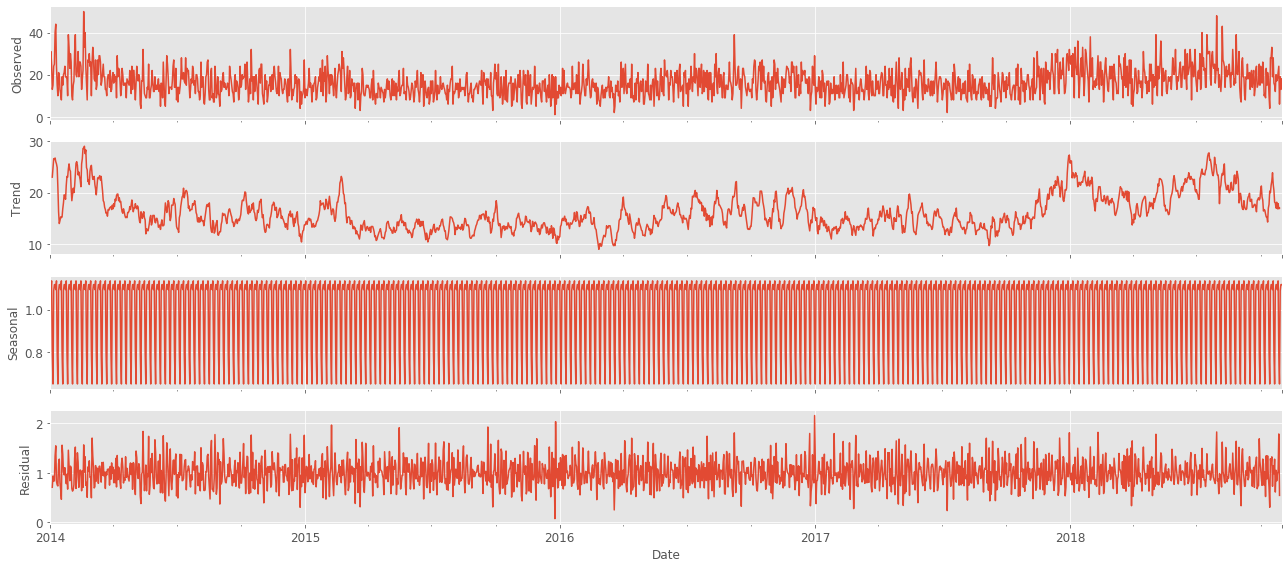

In [12]:
from pylab import rcParams
pd.plotting.register_matplotlib_converters()
rcParams['figure.figsize'] = (18, 8)
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

# Testing for Stationarity

In [65]:
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return pd.Series(diff)

result = adfuller(y.Delay)
print('ADF Statistic: %f' % result[0])
print('p-value: %.10f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.072796
p-value: 0.0286330279
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


The detrending method chosen was to take the log of the measured value and then take the difference twice with a lag of 1 day. Stationarity was confirmed with the dickey fuller test resulting in rejecting the null hypothesis that our data is not stationary. Transformed data can be seen below after achieving stationarity

# Baseline Model

to first identify the performance of our models, we will compare them against a baseline model that predicts based on the previous day's result. Think of the prediction as a one day shift backwards of the actual data. the method of prediction is called the walkthrough method which invoves only making one day predictions. This limitation works for us to predict on 5 years of data when we combine the current day's prediction into the training data for the next day's prediciton. This method is called the walkthrough method. The metric that will be used will be the root mean squared error.

In [6]:
# prepare data
X = y.Delay
train_size = int(len(X) * 0.70)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    #print('>Predicted=%.2f, Expected=%.2f' % (yhat, obs))
    # report performance
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print('RMSE: %.2f' % rmse)

RMSE: 8.51


# Autocorrelation and Partial Autocorrelation

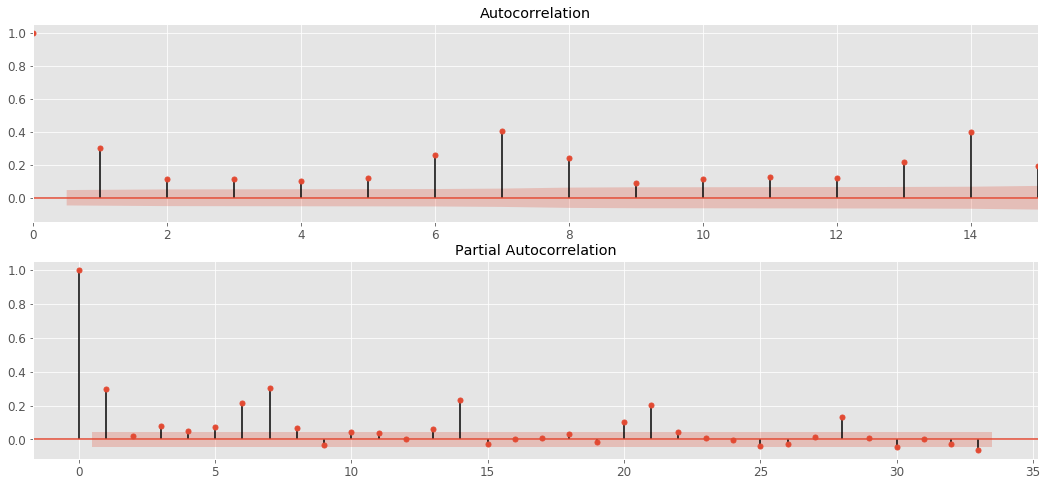

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(X, ax=plt.gca() )
plt.xlim(0,15)
plt.subplot(212)
plot_pacf(X, ax=plt.gca())
#plt.xlim(0,15)
plt.show()

There is clear presence of autocorrelation that seems to persist even past 14 days. There is also a seasonality pattern every 7 days which corresponds to the average work week.

# Model 1 - ARIMA

## Hyper Parameter Tuning 

Next we will iterate over three parameter values of p, d, and q for the ARIMA model to optimize on the RMSE score. It is important to note that this process never finished even running for 2 days straight, so the best score was taken up until that point.

In [ ]:

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in tqdm(p_values):
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                    print(datetime.now())
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 
# load dataset
# evaluate parameters
p_values = range(0,10)
d_values = range(0, 3)
q_values = range(0, 10)
warnings.filterwarnings("ignore")
evaluate_models(y.Delay, p_values, d_values, q_values)

#ARIMA(2, 1, 3) MSE=5.974
#2019-12-06 06:54:06.916845
#ARIMA(2, 1, 5) MSE=5.950
#2019-12-06 11:15:40.226882

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

ARIMA(2, 1, 6) MSE=5.957
2019-12-07 17:14:20.591082


Z:\Users\Don\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
Z:\Users\Don\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


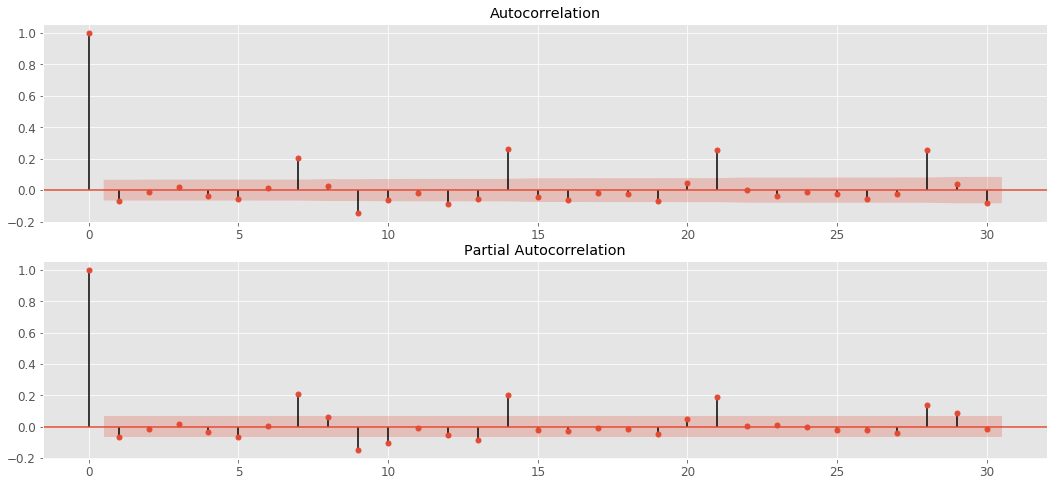

In [33]:

X = y.Delay
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-foward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
plt.figure()
plt.subplot(211)
plot_acf(residuals, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca())
plt.show()

It is clear that there is still some autocorrelation left in the dataset after all the optimizing that was done so there is still some room for improvement. However for the purposes of exploring additional methods, we will move on with FB Prophet model.

# Model 2 - FB Prophet

In [39]:
df.head()

,ds,y
0,2014-01-01,28
1,2014-01-02,31
2,2014-01-03,25
3,2014-01-04,13
4,2014-01-05,15


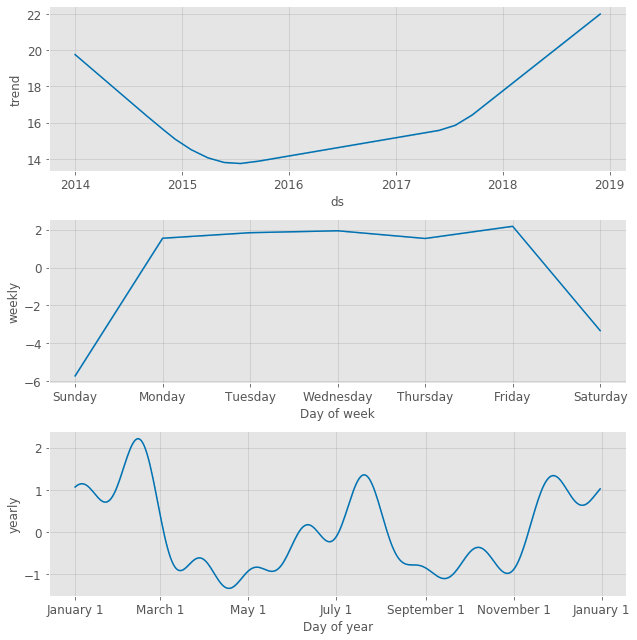

In [19]:
df = y.reset_index()
df.columns = ['ds', 'y']

model = Prophet(daily_seasonality=False)
model.fit(df.reset_index())

future_data = model.make_future_dataframe(periods=30, freq = 'd')
forecast_data = model.predict(future_data)
model.plot_components(forecast_data);

## Hyper Parameter Tuning

Now that we understand the basic working of using prophet model, we will now try to optimize the performance using hyper parameter tuning. The model takes in a special holiday parameter in the form of a dataframe so we will manually create one below.

In [9]:
holidays = {'2014-01-01': 'Bankholiday','2014-02-17': 'Bankholiday','2014-04-18': 'Bankholiday',
            '2014-04-21': 'Bankholiday','2014-05-19': 'Bankholiday','2014-07-01': 'Bankholiday',
            '2014-08-04': 'Bankholiday','2014-09-01': 'Bankholiday','2014-10-13': 'Bankholiday',   
            '2014-11-11': 'Bankholiday','2014-12-25': 'Bankholiday','2014-12-26': 'Bankholiday',
            '2015-01-01': 'Bankholiday','2015-02-16': 'Bankholiday','2015-04-03': 'Bankholiday',
            '2015-04-06': 'Bankholiday','2015-05-18': 'Bankholiday','2015-07-01': 'Bankholiday',
            '2015-08-03': 'Bankholiday','2015-09-07': 'Bankholiday','2015-10-12': 'Bankholiday',   
            '2015-11-11': 'Bankholiday','2015-12-25': 'Bankholiday','2015-12-26': 'Bankholiday',        
            '2016-01-01': 'Bankholiday','2016-02-15': 'Bankholiday','2016-03-25': 'Bankholiday',
            '2016-03-28': 'Bankholiday','2016-05-23': 'Bankholiday','2016-07-01': 'Bankholiday',
            '2016-08-01': 'Bankholiday','2016-09-05': 'Bankholiday','2016-10-10': 'Bankholiday',   
            '2016-11-11': 'Bankholiday','2016-12-25': 'Bankholiday','2016-12-26': 'Bankholiday',      
            '2017-01-01': 'Bankholiday','2017-02-20': 'Bankholiday','2017-04-14': 'Bankholiday', 
            '2017-04-17': 'Bankholiday','2017-05-22': 'Bankholiday','2017-07-01': 'Bankholiday',
            '2017-08-07': 'Bankholiday','2017-09-04': 'Bankholiday','2017-10-09': 'Bankholiday',   
            '2017-11-11': 'Bankholiday','2017-12-25': 'Bankholiday','2017-12-26': 'Bankholiday',     
            '2018-01-01': 'Bankholiday','2018-02-19': 'Bankholiday','2018-03-30': 'Bankholiday', 
            '2018-04-02': 'Bankholiday','2018-05-21': 'Bankholiday','2018-07-02': 'Bankholiday',
            '2018-08-06': 'Bankholiday','2018-09-03': 'Bankholiday','2018-10-08': 'Bankholiday',   
            '2018-11-11': 'Bankholiday','2018-12-25': 'Bankholiday','2018-12-26': 'Bankholiday'}

holidays = pd.DataFrame(holidays.items(), columns=['ds', 'holiday'])
holidays.ds = pd.to_datetime(holidays.ds)
holidays['lower_window'] = -6
holidays['upper_window'] = 6

In [11]:
import warnings
n_changepoints = range(0,15)
yearly_seasonality = ['auto', 11]
weekly_seasonality = [11]
seasonality_mode = ['additive','multiplicative']
seasonality_prior_scale = [20, 30]
changepoint_prior_scale = [.1, .15]
holidays_prior_scale = [14, 7, 30]
best_score, best_cfg = float("inf"), None

warnings.filterwarnings("ignore")
for i in tqdm(n_changepoints):
    for j in yearly_seasonality:
        for k in seasonality_mode:
            for l in seasonality_prior_scale:
                for m in changepoint_prior_scale:
                    for n in holidays_prior_scale:
                        cfg = {'n_changepoints': i,
                               'yearly_seasonality': j,
                               'seasonality_mode': k,
                               'seasonality_prior_scale': l,
                               'changepoint_prior_scale': m,
                               'holidays_prior_scale': n}
                        
                        try:
                            model = Prophet(daily_seasonality=True, 
                                            n_changepoints=i,
                                            yearly_seasonality=j,
                                            seasonality_mode=k,
                                            seasonality_prior_scale=l,
                                            changepoint_prior_scale=m,
                                            holidays_prior_scale=n,
                                            holidays=holidays)
                            df = df.reset_index()

                        
                            model.fit(df)

                            future_data = model.make_future_dataframe(periods=30, freq = 'd')
                            forecast_data = model.predict(future_data)
                            forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

                            df = df.set_index('ds') 

                            forecast_data = forecast_data.set_index('ds')
                            viz_df = df.join(forecast_data[['yhat', 'yhat_lower','yhat_upper']], how='outer')

                            y_forecasted = viz_df.loc['2018-01-01':'2018-10-31', 'y']
                            y_truth = viz_df.loc['2018-01-01':'2018-10-31', 'yhat']
                            rmse = np.sqrt(((np.subtract(y_forecasted, y_truth)) ** 2).mean())
                        except:
                            continue
                        
                        
    
    
                        if rmse < best_score:
                            best_score, best_cfg = rmse, cfg
    
print('Best Prophet (%s) RMSE=%.3f' % (best_cfg, best_score))

100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [11:42:51<00:00, 2811.46s/it]

Best Prophet ({'n_changepoints': 14, 'yearly_seasonality': 'auto', 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20, 'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 7}) RMSE=5.393


# Modeling



In [25]:

model = Prophet(daily_seasonality=True,
                n_changepoints=14,
                yearly_seasonality='auto',
                seasonality_mode='multiplicative',
                seasonality_prior_scale=20,
                changepoint_prior_scale= 0.15,
                holidays_prior_scale=7,
                holidays=holidays)
df = df.reset_index()
model.fit(df)
future_data = model.make_future_dataframe(periods=30, freq = 'd', include_history=True)
forecast_data = model.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

df = df.set_index('ds') 
forecast_data = forecast_data.set_index('ds')
viz_df = df.join(forecast_data[['yhat', 'yhat_lower','yhat_upper']], how='outer')

pred = viz_df.loc['2018-01-01':'2018-10-31', 'y']
test = viz_df.loc['2018-01-01':'2018-10-31', 'yhat']
rmse = np.sqrt(((np.subtract(pred, test)) ** 2).mean())
rmse

5.392542520291662

Through optimizing the fb prophet model we are able to make around an 8% improvement on the ARIMA performance which is pretty good. Below we plot our predictions and actual delay data on top of each other to observe how close it is. On inspectionb the model is able to capture the widths of the peaks and dips in delays very well. On the other hand it fails to capture the occasional spike in delays.

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 <a list of 7 Text yticklabel objects>)

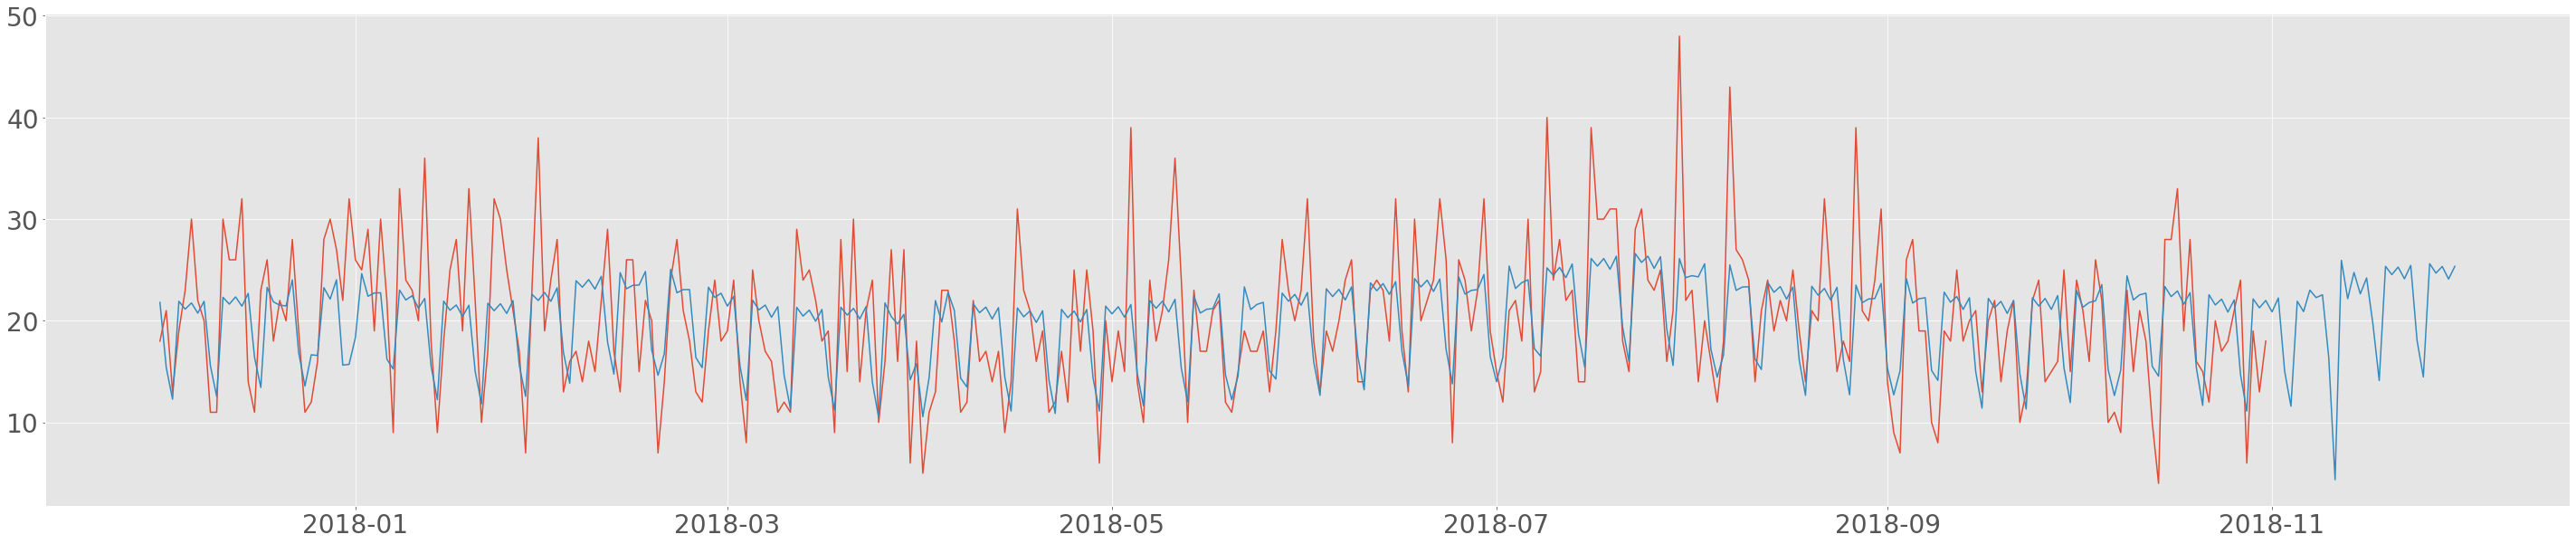

In [27]:
plt.figure(figsize = (50, 10))
trunc_data = viz_df.tail(365)

plt.plot(trunc_data.index, trunc_data.y)
plt.plot(trunc_data.index, trunc_data.yhat)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
#viz_df[['y_orig', 'yhat_rescaled']].plot()

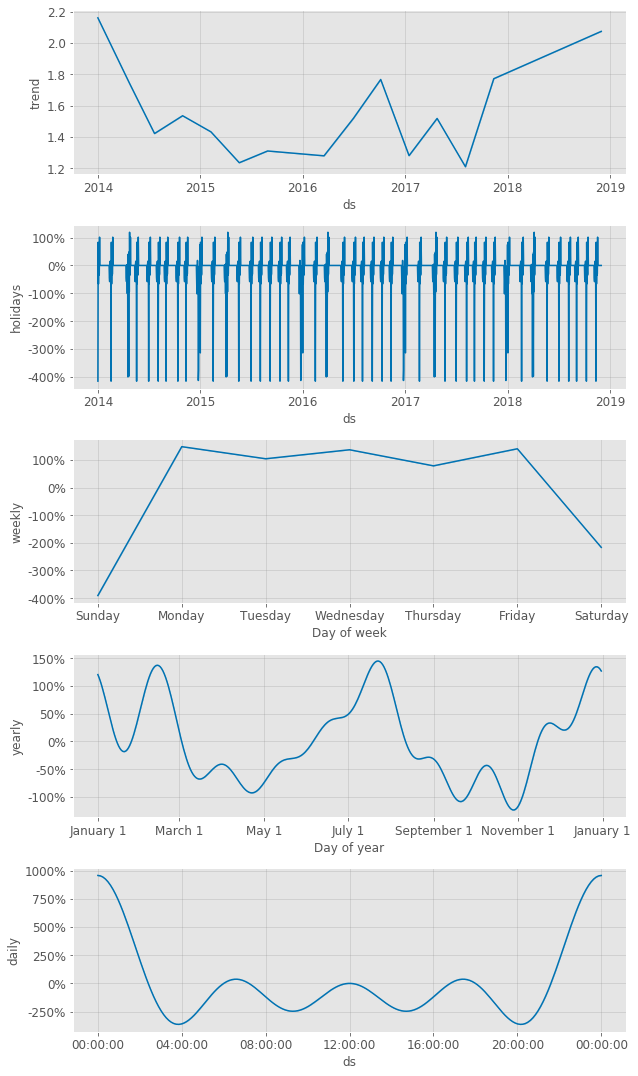

In [47]:
model.plot_components(forecast_data.reset_index());

Overall the performance is good on a normal given day but it seems to be doing poorly on special holidays. For the purposes of this project, only statutory holidays were captured, but there are a slew of other holidays ranging from religious, cultural holidays. I also didnt account for big sporting events when a toronto sports team is doing well, the foot traffic would increase as seen in Toronto when the Raptors won the championships in 2018.
  
There are other unforseen causes that have caused major delays in the past like power outages, or freak storms. These outliers would also make it difficult to have accurate forecasts.  

Below is a sample of a couple of the worst seen days for the subway in delays and the corresponding events that happened in toronto that day. Some of the events are a clear cause in the number in delays and others are not so clear.

In [51]:
viz_df['y_diff'] = abs(viz_df.y - viz_df.yhat)
df_2018 = viz_df.loc['2018-01-01':'2018-10-31'].sort_values(by='y_diff', ascending=False)
df_2018.head(5)

,index,y,yhat,yhat_lower,yhat_upper,y_diff
ds,,,,,,
2018-07-30,1671.0,48.0,26.120453,20.532454,32.041346,21.879547
2018-08-07,1679.0,43.0,25.491132,19.488069,32.179073,17.508868
2018-05-04,1584.0,39.0,21.609606,15.379020,27.865491,17.390394
2018-01-30,1490.0,38.0,21.996822,15.940680,28.392184,16.003178
2018-08-27,1699.0,39.0,23.510072,17.046787,29.399163,15.489928


2018-07-30 - ???  
2018-08-07 - Flooding occurred in one of the stations, meanwhile a small fire broke at another one   
2018-05-04 - Wind Storm causes damage across Toronto  
2018-01-30 - ???  
2018-08-27 - The CNE is offering free admission for two days this week  

Keeping in mind that predicting the above events could prove to be extremely difficult, I think the TTC could create a lot of value with the seasonality information. For instance, it could ramp up staffing to deal with an increase in ridership or an increase in first responders to resove delays quicker. Higher rider satisfaction could ultimately lead to people who would rely on this mode of transit and would be more likely to not resort to other modes of transportation. The bonus side effect to this would be that there would be less cars on the road which means less traffic and pollution.